For this example we will use **CamVid** dataset. It is a set of:
 - **train** images + segmentation masks
 - **validation** images + segmentation masks
 - **test** images + segmentation masks
 
All images have 320 pixels height and 480 pixels width.
For more inforamtion about dataset visit http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/.

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
DATA_DIR = './data/CamVid/'

# load repo with data if it is not exists
if not os.path.exists(DATA_DIR):
    print('Loading data...')
    os.system('git clone https://github.com/alexgkendall/SegNet-Tutorial ./data')
    print('Done!')

In [3]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

### Dataloader

Writing helper class for data extraction, tranformation and preprocessing  
https://pytorch.org/docs/stable/data

In [4]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

In [5]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

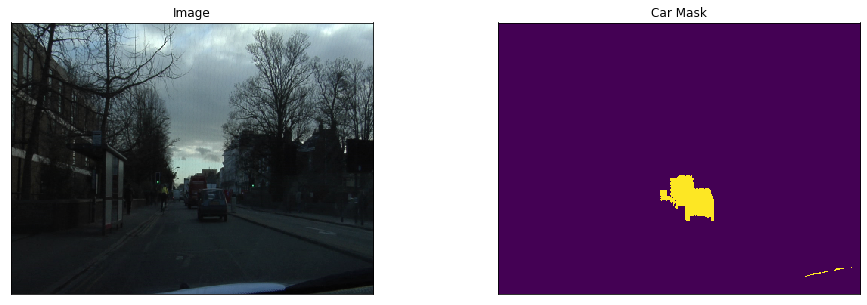

In [6]:
# Lets look at data we have

dataset = Dataset(x_train_dir, y_train_dir, classes=['car', 'road'])

image, mask = dataset[4] # get some sample
visualize(
    image=image, 
    car_mask=mask.squeeze()[...,0],
)

### Augmentations

In [7]:
import albumentations as albu

def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

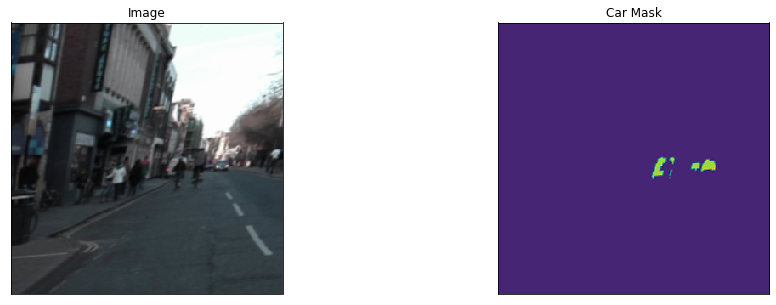

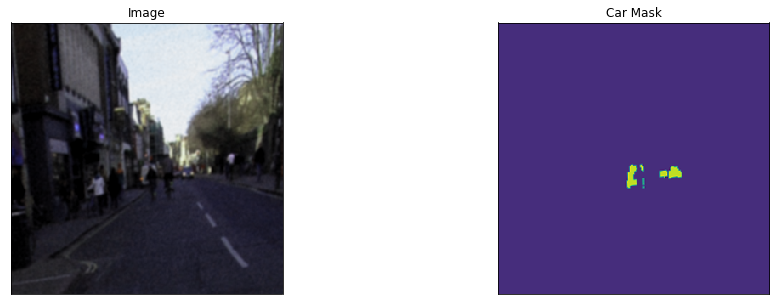

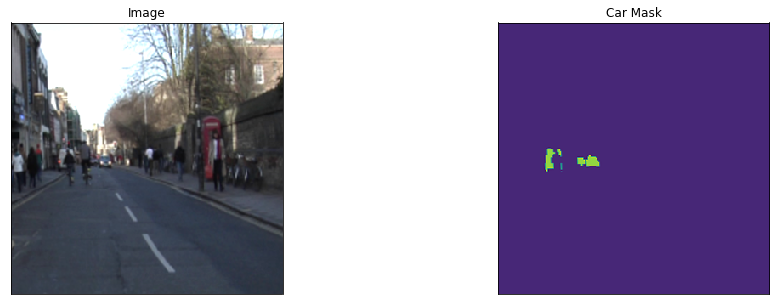

In [8]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    classes=['car', 'road'],
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[1]
    visualize(image=image, car_mask=mask[...,0])

### Create model and train

In [9]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

ENCODER = 'resnet18'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
           'tree', 'signsymbol', 'fence', 'car', 
           'pedestrian', 'bicyclist']
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
ACTIVATION = 'softmax2d' # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cuda'
LEARNING_RATE = 1e-4
EPOCHS = 10

# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=n_classes, 
    activation=ACTIVATION,
)

# model = smp.Unet(encoder_name=ENCODER,
#                  encoder_weights=ENCODER_WEIGHTS,
#                  classes=n_classes,
#                  activation=ACTIVATION)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [10]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

In [11]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
    smp.utils.metrics.Fscore(),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=LEARNING_RATE),
])

In [12]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [13]:
# train model for 40 epochs

max_score = 0

for i in range(0, EPOCHS):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './fpn_best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 101/101 [00:02<00:00, 49.17it/s, dice_loss - 0.3012, iou_score - 0.5423, fscore - 0.7027]
Model saved!

Epoch: 1
valid: 100%|██████████| 101/101 [00:02<00:00, 48.86it/s, dice_loss - 0.208, iou_score - 0.6597, fscore - 0.7947]
Model saved!

Epoch: 2
valid: 100%|██████████| 101/101 [00:02<00:00, 48.62it/s, dice_loss - 0.2064, iou_score - 0.6612, fscore - 0.7957]
Model saved!

Epoch: 3
valid: 100%|██████████| 101/101 [00:02<00:00, 49.31it/s, dice_loss - 0.1986, iou_score - 0.6716, fscore - 0.8032]
Model saved!

Epoch: 4
valid: 100%|██████████| 101/101 [00:02<00:00, 50.03it/s, dice_loss - 0.1949, iou_score - 0.6772, fscore - 0.8073]
Model saved!

Epoch: 5
valid: 100%|██████████| 101/101 [00:02<00:00, 46.80it/s, dice_loss - 0.196, iou_score - 0.6748, fscore - 0.8056]

Epoch: 6
valid: 100%|██████████| 101/101 [00:02<00:00, 46.66it/s, dice_loss - 0.1979, iou_score - 0.6729, fscore - 0.8041]

Epoch: 7
valid: 100%|██████████| 101/101 [00:02<00:00, 46.01it/s, di

### Anomaly detection based on High Entropy

In [14]:
# load best saved checkpoint
best_model = torch.load('./fpn_best_model.pth')

In [15]:
# create test dataset
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset)

In [16]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir, 
    classes=CLASSES,
)

In [17]:
def entropy(mask_np):
    # mask_np.shape = (3, N, M)
    e = np.mean( (-mask_np * np.log2(mask_np)).sum(axis=0) )
    return e

In [18]:
def margin(mask_np):
    rev_probas = np.sort(mask_np, axis=0)[::-1, ...]
    margins_matrix = rev_probas[0,...] - rev_probas[1,...]
    mean_margin = np.mean(margins_matrix)
    return mean_margin

In [19]:
from tqdm import tqdm

entropies = []
margins = []
for i in tqdm(range(len(test_dataset))):    
    image, gt_mask = test_dataset[i]
    image_vis = test_dataset_vis[i][0].astype('uint8')
        
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    mask_np = pr_mask.squeeze().cpu().numpy()
    entropies.append(entropy(mask_np))
    margins.append(margin(mask_np))

100%|██████████| 233/233 [00:19<00:00, 12.25it/s]


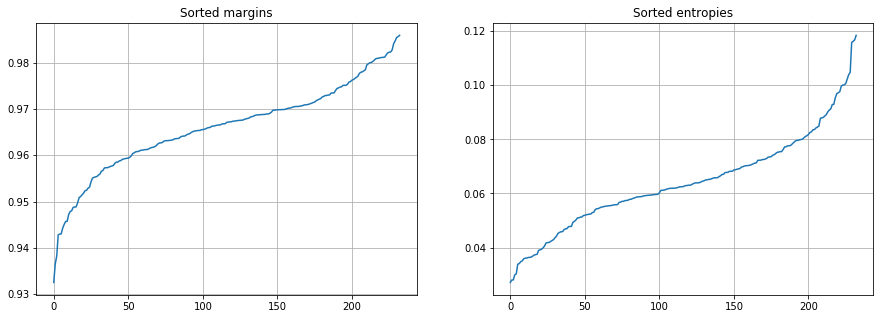

In [20]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title('Sorted margins')
plt.plot(np.sort(margins))
plt.grid()

plt.subplot(1,2,2)
plt.title('Sorted entropies')
plt.plot(np.sort(entropies))
plt.grid();

### Most confident examples

Min entropy: 0.027120977640151978, Entropy: 0.027120977640151978, Max entropy: 0.11845281720161438
Min margin: 0.9325309991836548, Margin: 0.985883355140686, Max margin: 0.985883355140686


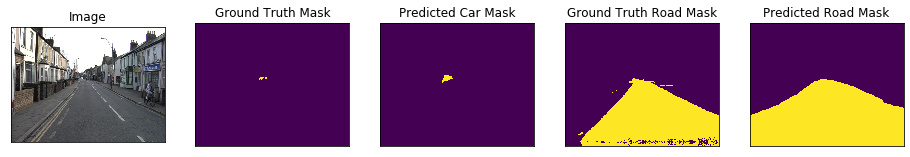

Min entropy: 0.027120977640151978, Entropy: 0.028011417016386986, Max entropy: 0.11845281720161438
Min margin: 0.9325309991836548, Margin: 0.9856261610984802, Max margin: 0.985883355140686


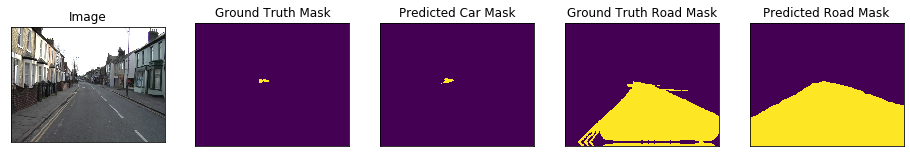

Min entropy: 0.027120977640151978, Entropy: 0.028050292283296585, Max entropy: 0.11845281720161438
Min margin: 0.9325309991836548, Margin: 0.9854200482368469, Max margin: 0.985883355140686


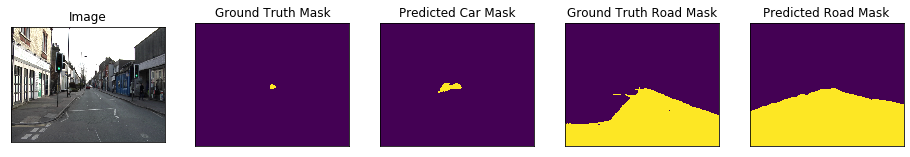

Min entropy: 0.027120977640151978, Entropy: 0.03028867579996586, Max entropy: 0.11845281720161438
Min margin: 0.9325309991836548, Margin: 0.9846757054328918, Max margin: 0.985883355140686


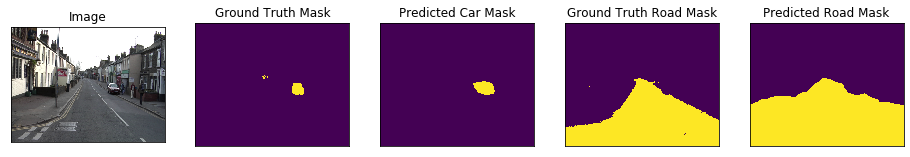

Min entropy: 0.027120977640151978, Entropy: 0.029941344633698463, Max entropy: 0.11845281720161438
Min margin: 0.9325309991836548, Margin: 0.984092652797699, Max margin: 0.985883355140686


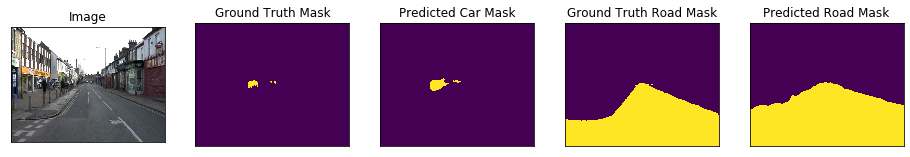

In [21]:
# Model is mostly uncertain in images with High entropy
NUM_UNCERTAIN_IMAGES = 5
# selection = (np.argsort(entropies))[:NUM_UNCERTAIN_IMAGES]
selection = (np.argsort(margins))[::-1][:NUM_UNCERTAIN_IMAGES]

for i in selection:
    print(f'Min entropy: {np.min(entropies)}, Entropy: {entropies[i]}, Max entropy: {np.max(entropies)}')
    print(f'Min margin: {np.min(margins)}, Margin: {margins[i]}, Max margin: {np.max(margins)}')
    image, gt_mask = test_dataset[i]
    image_vis = test_dataset_vis[i][0].astype('uint8')
        
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    mask_np = pr_mask.squeeze().cpu().numpy().round()
    
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask[8,...],
        predicted_car_mask=mask_np[8,...],
        ground_truth_road_mask=gt_mask[3,...],
        predicted_road_mask=mask_np[3,...],
    )

### Most uncertain examples

Min entropy: 0.027120977640151978, Entropy: 0.11679285764694214, Max entropy: 0.11845281720161438
Min margin: 0.9325309991836548, Margin: 0.9325309991836548, Max margin: 0.985883355140686


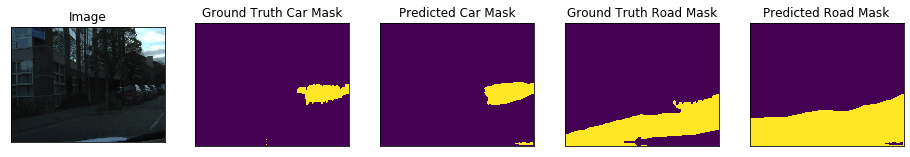

Min entropy: 0.027120977640151978, Entropy: 0.11584882438182831, Max entropy: 0.11845281720161438
Min margin: 0.9325309991836548, Margin: 0.9365216493606567, Max margin: 0.985883355140686


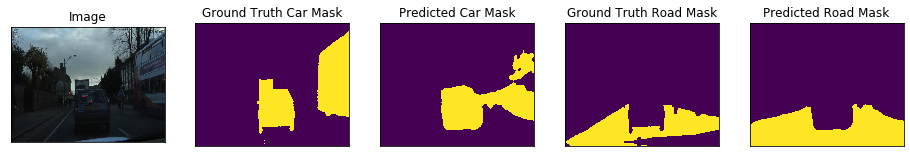

Min entropy: 0.027120977640151978, Entropy: 0.11845281720161438, Max entropy: 0.11845281720161438
Min margin: 0.9325309991836548, Margin: 0.9382219910621643, Max margin: 0.985883355140686


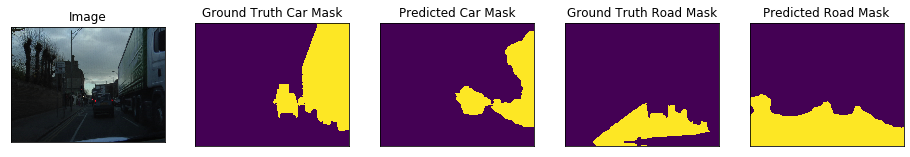

Min entropy: 0.027120977640151978, Entropy: 0.1047782152891159, Max entropy: 0.11845281720161438
Min margin: 0.9325309991836548, Margin: 0.9428026080131531, Max margin: 0.985883355140686


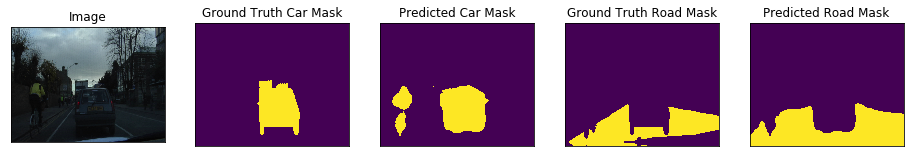

Min entropy: 0.027120977640151978, Entropy: 0.10393679887056351, Max entropy: 0.11845281720161438
Min margin: 0.9325309991836548, Margin: 0.9429706335067749, Max margin: 0.985883355140686


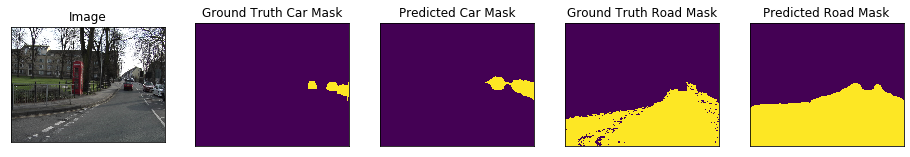

In [22]:
# Model is mostly uncertain in images with High entropy
NUM_UNCERTAIN_IMAGES = 5
#selection = (np.argsort(entropies)[::-1])[:NUM_UNCERTAIN_IMAGES]
selection = np.argsort(margins)[:NUM_UNCERTAIN_IMAGES]

for i in selection:
    print(f'Min entropy: {np.min(entropies)}, Entropy: {entropies[i]}, Max entropy: {np.max(entropies)}')
    print(f'Min margin: {np.min(margins)}, Margin: {margins[i]}, Max margin: {np.max(margins)}')
    image, gt_mask = test_dataset[i]
    image_vis = test_dataset_vis[i][0].astype('uint8')
        
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    mask_np = pr_mask.squeeze().cpu().numpy().round()
    
    visualize(
        image=image_vis, 
        ground_truth_car_mask=gt_mask[8,...],
        predicted_car_mask=mask_np[8,...],
        ground_truth_road_mask=gt_mask[3,...],
        predicted_road_mask=mask_np[3,...],
    )